In [37]:
# Step 1: Import all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, f1_score
)

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    StackingClassifier
)
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')



In [89]:
# Step 2: Load Kaggle AI4I Predictive Maintenance Dataset
data = pd.read_csv("/content/predictive_maintenance.csv")

# Drop unnecessary columns
for col in ['UDI', 'Product ID']:
    if col in data.columns:
        data.drop(col, axis=1, inplace=True)

# One-hot encode categorical variables (if any)
data = pd.get_dummies(data, drop_first=True)

# Separate features and target
X = data.drop('Target', axis=1)
y = data['Target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features for ML algorithms that need normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data ready for training")


✅ Data ready for training


In [90]:
# Step 3: Define baseline ML models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=300, random_state=42)
}

# Train and evaluate baseline performance
model_scores = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    acc = model.score(X_test_scaled, y_test)
    model_scores[name] = acc
    print(f"✅ {name} Accuracy: {acc:.4f}")

# Display baseline accuracy comparison
results_df = pd.DataFrame(list(model_scores.items()), columns=['Model', 'Accuracy'])
results_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print("\n🏆 Baseline Model Performance:\n", results_df)


✅ Logistic Regression Accuracy: 0.9990
✅ Decision Tree Accuracy: 0.9965
✅ SVM Accuracy: 0.9990
✅ Random Forest Accuracy: 0.9990
✅ XGBoost Accuracy: 0.9990
✅ Gradient Boosting Accuracy: 0.9990
✅ Neural Network Accuracy: 0.9990

🏆 Baseline Model Performance:
                  Model  Accuracy
0  Logistic Regression    0.9990
2                  SVM    0.9990
3        Random Forest    0.9990
5    Gradient Boosting    0.9990
4              XGBoost    0.9990
6       Neural Network    0.9990
1        Decision Tree    0.9965


In [91]:
# Step 4: Hyperparameter tuning using GridSearchCV

# Check if y_train has more than one class before proceeding
if len(y_train.unique()) < 2:
    print("❌ Error: The target variable 'y_train' contains only one class. "
          "Cannot perform classification. Please check your dataset's target column "
          "or preprocessing steps to ensure there are at least two classes.")
else:
    # Decision Tree
    param_dt = {'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10]}
    grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_dt, cv=3, n_jobs=-1, scoring='f1')
    grid_dt.fit(X_train_scaled, y_train)
    print("✅ Best Decision Tree Parameters:", grid_dt.best_params_)

    # SVM
    param_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
    grid_svm = GridSearchCV(SVC(probability=True, random_state=42), param_svm, cv=3, n_jobs=-1, scoring='f1')
    grid_svm.fit(X_train_scaled, y_train)
    print("✅ Best SVM Parameters:", grid_svm.best_params_)

    # Gradient Boosting
    param_gb = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3, 5, 7]}
    grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_gb, cv=3, n_jobs=-1, scoring='f1')
    grid_gb.fit(X_train_scaled, y_train)
    print("✅ Best Gradient Boosting Parameters:", grid_gb.best_params_)


✅ Best Decision Tree Parameters: {'max_depth': 5, 'min_samples_split': 5}
✅ Best SVM Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
✅ Best Gradient Boosting Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


In [92]:
# Step 5: Evaluate tuned models
tuned_models = {
    "Decision Tree": grid_dt.best_estimator_,
    "SVM": grid_svm.best_estimator_,
    "Gradient Boosting": grid_gb.best_estimator_
}

performance_summary = []

for name, model in tuned_models.items():
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    print(f"\n📈 {name} Results:")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc:.4f}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    performance_summary.append([name, f1, roc])

# Summary table
performance_df = pd.DataFrame(performance_summary, columns=['Model', 'F1-Score', 'ROC-AUC'])
performance_df.sort_values(by='ROC-AUC', ascending=False, inplace=True)
print("\n🏁 Model Evaluation Summary:\n", performance_df)



📈 Decision Tree Results:
F1-Score: 0.9833
ROC-AUC: 0.9904
[[1939    0]
 [   2   59]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1939
           1       1.00      0.97      0.98        61

    accuracy                           1.00      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000


📈 SVM Results:
F1-Score: 0.9833
ROC-AUC: 0.9861
[[1939    0]
 [   2   59]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1939
           1       1.00      0.97      0.98        61

    accuracy                           1.00      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000


📈 Gradient Boosting Results:
F1-Score: 0.9833
ROC-AUC: 0.9726
[[1939    0]
 [   2   59]]
              precision    recall  f1-score   support

           0       1.00      1.00      

In [93]:
from sklearn.metrics import classification_report
import pandas as pd

performance_data = []

for name, model in models.items():
    # Get predictions to compute classification report
    y_pred = model.predict(X_test_scaled)

    # Generate classification report and extract metrics for class 1
    report = classification_report(y_test, y_pred, output_dict=True)

    accuracy = report['accuracy']
    precision_class_1 = report['1']['precision']
    recall_class_1 = report['1']['recall']
    f1_score_class_1 = report['1']['f1-score']

    performance_data.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision (Class 1)': precision_class_1,
        'Recall (Class 1)': recall_class_1,
        'F1-Score (Class 1)': f1_score_class_1
    })

# Create a DataFrame from the collected data
performance_df = pd.DataFrame(performance_data)

# Sort by F1-Score for class 1, as it's often a good metric for imbalanced datasets
performance_df = performance_df.sort_values(by='F1-Score (Class 1)', ascending=False).reset_index(drop=True)

print("\n🚀 Classifier Performance Summary (Accuracy, Precision, Recall, F1-Score for Class 1):\n")
display(performance_df)


🚀 Classifier Performance Summary (Accuracy, Precision, Recall, F1-Score for Class 1):



,Model,Accuracy,Precision (Class 1),Recall (Class 1),F1-Score (Class 1)
0,Logistic Regression,0.9990,1.000000,0.967213,0.983333
1,SVM,0.9990,1.000000,0.967213,0.983333
2,Random Forest,0.9990,1.000000,0.967213,0.983333
3,Gradient Boosting,0.9990,1.000000,0.967213,0.983333
4,XGBoost,0.9990,1.000000,0.967213,0.983333
5,Neural Network,0.9990,1.000000,0.967213,0.983333
6,Decision Tree,0.9965,0.921875,0.967213,0.944000


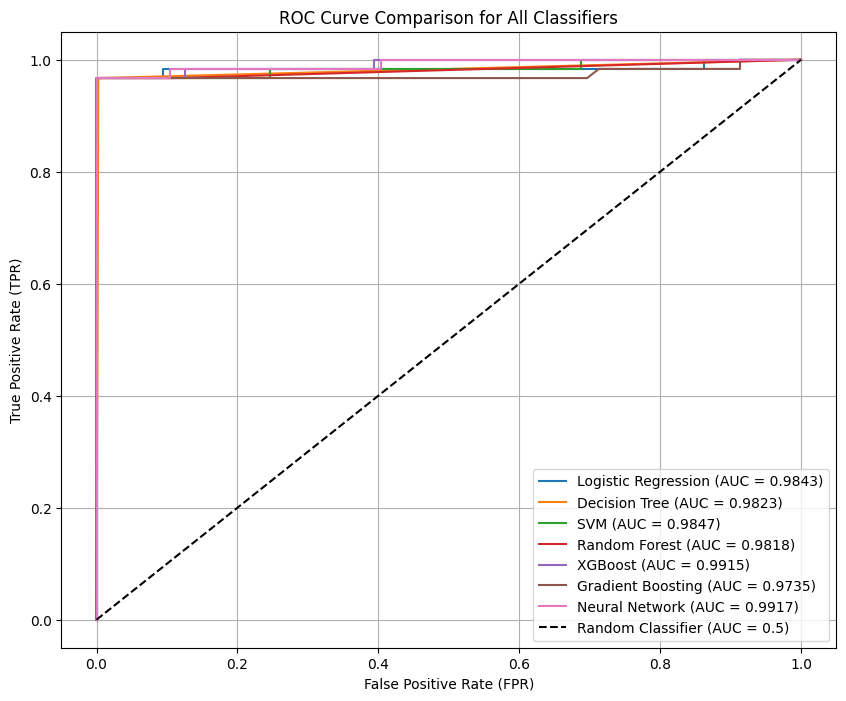


--- ROC AUC Scores ---
Logistic Regression: 0.9843
Decision Tree: 0.9823
SVM: 0.9847
Random Forest: 0.9818
XGBoost: 0.9915
Gradient Boosting: 0.9735
Neural Network: 0.9917


In [94]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))

roc_auc_scores = {}

for name, model in models.items():
    # Get predicted probabilities for the positive class
    # Check if the model has predict_proba (some models like SVC without probability=True might not)
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # For models without predict_proba, use decision_function if available
        # Or skip if neither is available (though most classifiers have one)
        if hasattr(model, 'decision_function'):
            y_prob = model.decision_function(X_test_scaled)
            # Scale to [0,1] for ROC if necessary (not strictly needed for roc_curve but good practice)
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
        else:
            print(f"Warning: Model {name} does not have predict_proba or decision_function. Skipping ROC curve.")
            continue

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_prob)
    roc_auc_scores[name] = auc_score

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')

# Plot the random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison for All Classifiers')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\n--- ROC AUC Scores ---")
for name, auc in roc_auc_scores.items():
    print(f"{name}: {auc:.4f}")

In [95]:
# Step 7: Ensemble Stacking
base_learners = [
    ('Decision Tree', grid_dt.best_estimator_),
    ('SVM', grid_svm.best_estimator_),
    ('Gradient Boosting', grid_gb.best_estimator_),
    ('Random Forest', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('XGBoost', XGBClassifier(eval_metric='logloss', random_state=42))
]

meta_learner = LogisticRegression(max_iter=1000, random_state=42)

stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1
)

stack_model.fit(X_train_scaled, y_train)
y_pred_stack = stack_model.predict(X_test_scaled)
y_prob_stack = stack_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
f1_stack = f1_score(y_test, y_pred_stack)
roc_stack = roc_auc_score(y_test, y_prob_stack)
print(f"\n🏆 Ensemble Stacking Model Performance:")
print(f"F1-Score: {f1_stack:.4f}")
print(f"ROC-AUC: {roc_stack:.4f}")



🏆 Ensemble Stacking Model Performance:
F1-Score: 0.9833
ROC-AUC: 0.9842


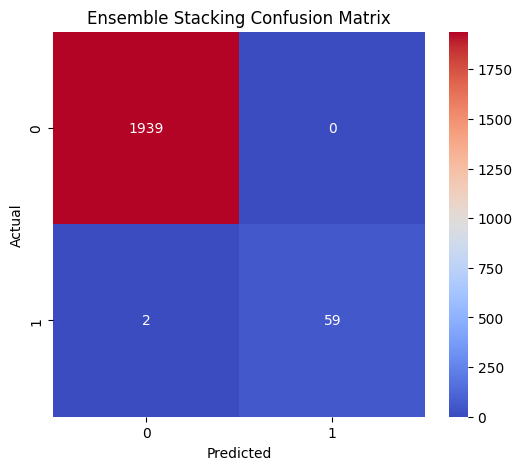

In [96]:
cm = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title('Ensemble Stacking Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [97]:
import joblib
joblib.dump(stack_model, 'ensemble_predictive_maintenance.pkl')
print("✅ Ensemble model saved successfully!")


✅ Ensemble model saved successfully!


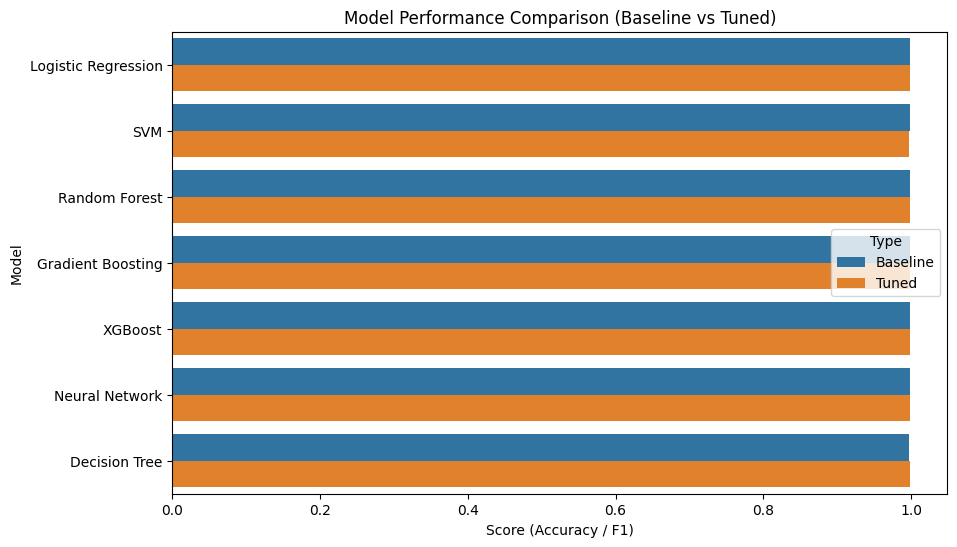

In [98]:
# Combine baseline and tuned results
final_results = pd.concat([
    results_df.rename(columns={'Accuracy': 'Score'}).assign(Type='Baseline'),
    performance_df.rename(columns={'F1-Score': 'Score'}).assign(Type='Tuned')
])

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Model', hue='Type', data=final_results)
plt.title('Model Performance Comparison (Baseline vs Tuned)')
plt.xlabel('Score (Accuracy / F1)')
plt.show()


In [99]:
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1
)
stack_model.fit(X_train_scaled, y_train)


StackingClassifier(cv=3,
                   estimators=[('Decision Tree',
                                DecisionTreeClassifier(max_depth=5,
                                                       min_samples_split=5,
                                                       random_state=42)),
                               ('SVM',
                                SVC(C=0.1, kernel='linear', probability=True,
                                    random_state=42)),
                               ('Gradient Boosting',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           random_state=42)),
                               ('Random Forest',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=42))...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42),
                   n_jobs=-1)

In [100]:
# Predict whether each machine failed (1) or not (0)
y_pred_stack = stack_model.predict(X_test_scaled)

# Add predictions to a DataFrame for easy inspection
results = X_test.copy()
results['Actual_Failure'] = y_test.values
results['Predicted_Failure'] = y_pred_stack

print(results.head(10))


      Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
6252                300.8                    310.3                    1538   
4684                303.6                    311.8                    1421   
1731                298.3                    307.9                    1485   
4742                303.3                    311.3                    1592   
4521                302.4                    310.4                    1865   
6340                300.5                    309.9                    1397   
576                 297.7                    309.7                    1440   
5202                303.7                    312.7                    1335   
6363                300.0                    309.6                    1618   
439                 297.4                    308.3                    1535   

      Torque [Nm]  Tool wear [min]  Type_L  Type_M  Failure Type_No Failure  \
6252         36.1              198    True   False            

In [101]:
# Example new machine input (in same order as X_train columns)
new_machine_data = np.array([
    [295.5, 310.2, 1500, 40.1, 0, 0, 0, 0, 0, 1, 0, 0]  # example values
])

# Scale with the same scaler used during training
new_scaled = scaler.transform(new_machine_data)

# Predict
prediction = stack_model.predict(new_scaled)[0]
probability = stack_model.predict_proba(new_scaled)[0][1]

# Show result
if prediction == 1:
    print(f"⚠️ Machine failure predicted! (Probability: {probability:.2f})")
else:
    print(f"✅ Machine is operating normally (Failure Probability: {probability:.2f})")


⚠️ Machine failure predicted! (Probability: 0.99)
